In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ISLP import load_data

from lifelines import \
    (KaplanMeierFitter ,
     CoxPHFitter)
from lifelines.statistics import \
    (logrank_test ,
     multivariate_logrank_test )
from ISLP.survival import sim_time

In [51]:
rng = np.random.default_rng(10)
N = 2000

Operators = rng.choice(np.arange(5, 16), N, replace=True)
Center = rng.choice(["A", "B", "C"], N, replace=True)
Time = rng.choice(["Morn.", "After.", "Even."], N, replace=True)
dataset = pd.DataFrame({"Operators": Operators, "Center": Center, "Time": Time})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Operators  2000 non-null   int64 
 1   Center     2000 non-null   object
 2   Time       2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [52]:
X = pd.get_dummies(dataset).astype(float)
X.drop(columns=["Center_A", "Time_After."], inplace=True)
X

,Operators,Center_B,Center_C,Time_Even.,Time_Morn.
0,13.0,0.0,1.0,0.0,0.0
1,15.0,0.0,0.0,1.0,0.0
2,7.0,1.0,0.0,0.0,1.0
3,7.0,0.0,1.0,0.0,1.0
4,13.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...
1995,9.0,0.0,0.0,0.0,1.0
1996,12.0,0.0,1.0,0.0,0.0
1997,7.0,0.0,1.0,0.0,1.0
1998,12.0,0.0,0.0,1.0,0.0


In [53]:
true_beta = np.array([0.04, -0.3, 0, 0.2, -0.2])
true_linpred = X.dot(true_beta)

hazard = lambda t: 1e-5 * t
cumulative_hazard = lambda t: 1e-5 * t**2 / 2

In [54]:
W = np.array([sim_time(l, cumulative_hazard, rng) for l in true_linpred])
dataset["Wait time"] = np.clip(W, 0, 1000)
dataset["Failed"] = rng.choice([1, 0], N, p=[0.9, 0.1])
dataset.head()

,Operators,Center,Time,Wait time,Failed
0,13,C,After.,525.064979,1
1,15,A,Even.,254.677835,1
2,7,B,Morn.,487.739224,1
3,7,C,Morn.,308.580292,1
4,13,C,Even.,154.174608,1


In [55]:
dataset["Failed"].mean()

0.9075

In [56]:
X["Wait time"] = dataset["Wait time"]
X["Failed"] = dataset["Failed"]

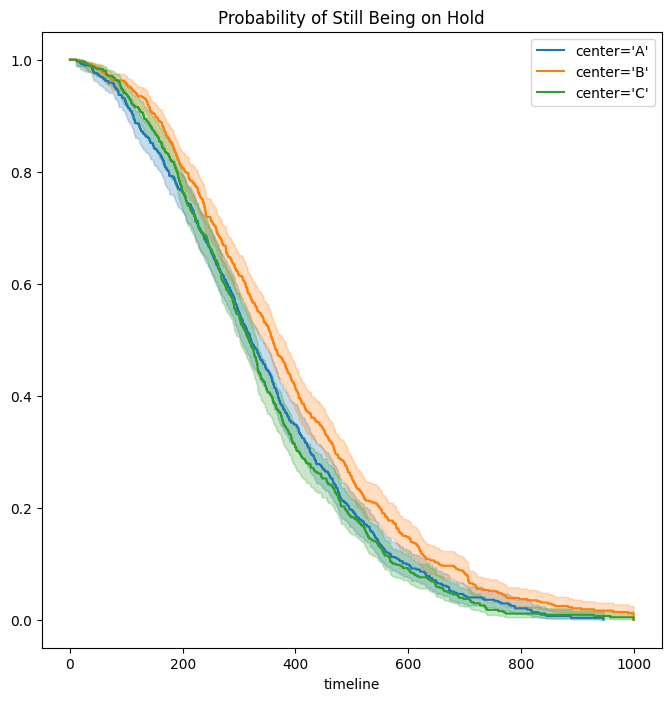

In [57]:
fig, ax = plt.subplots(figsize=(8,8))
by_center = {}
for center, df in dataset.groupby("Center"):
    by_center[center] = df
    km_center = KaplanMeierFitter()
    km_center.fit(df["Wait time"], df["Failed"])
    km_center.plot(label=f"{center=}", ax=ax)

ax.set_title("Probability of Still Being on Hold");

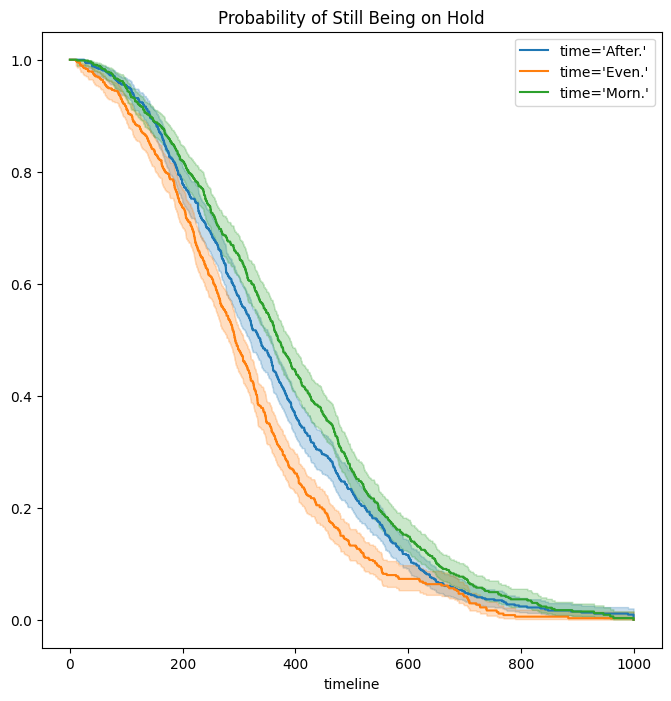

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
by_time = {}
for time, df in dataset.groupby("Time"):
    by_time[time] = df
    km_time = KaplanMeierFitter()
    km_time.fit(df["Wait time"], df["Failed"])
    km_time.plot(label=f"{time=}", ax=ax)
ax.set_title("Probability of Still Being on Hold");

In [59]:
multivariate_logrank_test(dataset["Wait time"], dataset["Center"], dataset["Failed"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          20.30 <0.005     14.65

In [60]:
multivariate_logrank_test(dataset["Wait time"], dataset["Time"], dataset["Failed"])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          49.90 <0.005     35.99

In [64]:
smallX = X[["Wait time", "Failed", "Center_B", "Center_C"]]
cox_center = CoxPHFitter().fit(smallX, "Wait time", "Failed")
cox_center.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          20.58 <0.005     14.85

In [65]:
smallX = X[["Wait time", "Failed", "Time_Even.", "Time_Morn."]]
cox_time = CoxPHFitter().fit(smallX, "Wait time", "Failed")
cox_time.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          48.12 <0.005     34.71

In [67]:
cox_all = CoxPHFitter().fit(X, "Wait time", "Failed")
cox_all.summary[["coef", "se(coef)", "p"]]

,coef,se(coef),p
covariate,,,
Operators,0.043934,0.007520,5.143589e-09
Center_B,-0.236060,0.058113,4.864162e-05
Center_C,0.012231,0.057518,8.316096e-01
Time_Even.,0.268845,0.057797,3.294956e-06
Time_Morn.,-0.148217,0.057334,9.733557e-03
